# Ionization Equilibrium

Now that we're able to calculate the ionization and recombination rates easily, let's try to calculate the ionization equilibrium. We want to do this very efficiently. This method will live on the `Element` class. 

In [97]:
import os
os.environ['XUVTOP'] = '/Users/willbarnes/ssw/packages/chianti/dbase/'

import numpy as np
from scipy.interpolate import splev,splrep,interp1d
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn
import fiasco
import plasmapy
import ChiantiPy.tools as ch_tools
import ChiantiPy.core as ch
import hissw

%matplotlib inline

In [98]:
temperature = np.logspace(4,9,100)*u.K

In [99]:
el = fiasco.Element('iron',temperature)

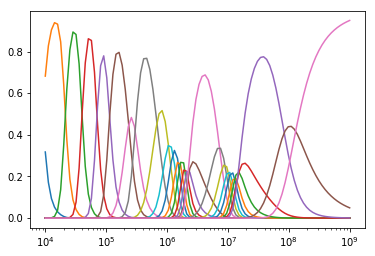

In [100]:
for ion in el:
    plt.plot(el.temperature,ion.ioneq)
plt.xscale('log')

Solve ionization equilibrium equations 

In [123]:
a_matrix = np.zeros(temperature.shape+(el.atomic_number+1,el.atomic_number+1))

In [132]:
for i in range(1,el.atomic_number):
    a_matrix[:,i,i] = -(el[i].ionization_rate() + el[i-1].recombination_rate()).value
    a_matrix[:,i,i-1] = el[i-1].ionization_rate().value
    a_matrix[:,i,i+1] = el[i].recombination_rate().value
a_matrix[:,0,0] = -el[0].ionization_rate().value
a_matrix[:,0,1] = el[0].recombination_rate().value
a_matrix[:,el.atomic_number,el.atomic_number] = -(el[el.atomic_number].ionization_rate().value + 
                                                  el[el.atomic_number-1].recombination_rate().value)
a_matrix[:,el.atomic_number,el.atomic_number-1] = el[el.atomic_number-1].ionization_rate().value

In [133]:
uu,ss,vv = np.linalg.svd(a_matrix)

In [134]:
yy = vv[:,-1,:]
yy = np.fabs(yy)
#yy = np.where(yy<0,0,yy)
yy /= np.sum(yy,axis=1)[:,np.newaxis]

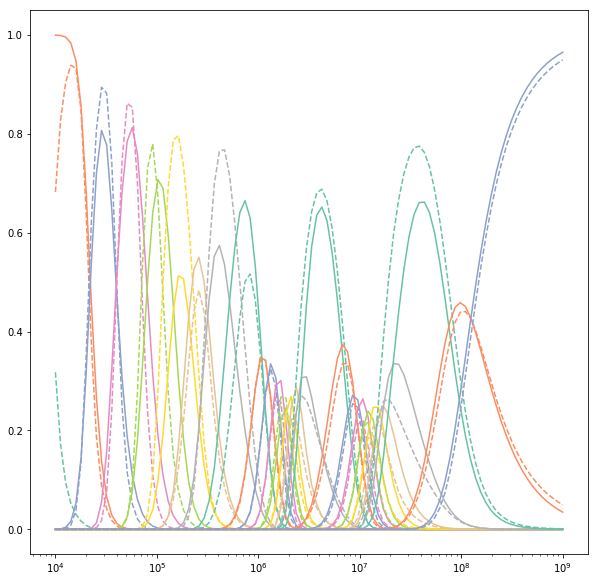

In [135]:
plt.figure(figsize=(10,10))
colors = seaborn.color_palette('Set2',n_colors=el.atomic_number+1)
for i in range(el.atomic_number+1):
    plt.plot(temperature,el[i].ioneq,'--',color=colors[i])
    plt.plot(temperature,yy[:,i],color=colors[i])
plt.xscale('log')
#plt.xlim([1e6,5e6])
#plt.ylim([0,0.5])

In [146]:
ionization_rates = np.zeros(temperature.shape+(el.atomic_number+1,))
recombination_rates = np.zeros(temperature.shape+(el.atomic_number+1,))

In [147]:
for i,ion in enumerate(el):
    ionization_rates[:,i] = ion.ionization_rate()
    recombination_rates[:,i] = ion.recombination_rate()

In [148]:
ir_diff = np.fabs(ionization_rates - recombination_rates)

In [149]:
i_pivot = np.argmin(ir_diff,axis=1)

In [156]:
yy_prime = np.zeros(temperature.shape+(el.atomic_number+1,))

In [160]:
yy_prime[np.array(range(i_pivot.shape[0])),i_pivot] = 0.5